In [1]:
# Import everything that we are going to need
import pandas as pd
import geopandas
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import scipy.interpolate

#for the reprojecting
import shapely.geometry
import pyproj
from shapely.geometry import Point, LineString, Polygon
from cartopy import crs as ccrs

#for finding the nearest points (to merge LULC data)
import heapq
import operator

#Regression packages (used for linear and polynomial regression)
import operator
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#for root finding and curve fitting
import scipy as sp
from scipy import optimize
from scipy.optimize import curve_fit


In [ ]:
##Checkpoints
##Checkpoint throughout code, where dataframes are saved as pickles mean each stage can be returned to without rerunning code
##Checkpoint 1: 2 dataframes containing the LST data and LULC data, with xy coordinate system
##Checkpoint 2: gdf2 with the urban flags from the closest 10 points from the LULC dataset are merged to each LST pixel point
##Checkpoint 3: gdf2 with the points for smoothing added (10 nearest points)

In [45]:
#Open the dataset
#Date 15/07/2007
#Terra MODIS
Terradata1030Z=xr.open_dataset('/neodc/eustace/data/satellite_skin_temperature/UOL/land/MODIS_Terra/L2/GT_MOG_2P/v2.1/2007/07/15/GT_SSD-L2-MOGSV_LST_2-20070715_103000-CUOL-0.01X0.01-V2.1.nc')


In [46]:
#Change from array to dataframe
df_Terradata1030Z = Terradata1030Z.to_dataframe()

In [47]:
#select a subset (Area containing Milan city centre and 39km around it, taken from Anniballe 2014)
#45.29<lat<45.64, 8.91<lon<9.42
subset_Terradata1030Z= df_Terradata1030Z[(df_Terradata1030Z.lat >45.29) & (df_Terradata1030Z.lat < 45.65) & (df_Terradata1030Z.lon > 8.91) & (df_Terradata1030Z.lon < 9.42)]

In [48]:
#Change the coordinate reference system
#lat and lon coordinates are not accurate as they are distorted by the shape of the map
subset_Terradata1030Z_df_geometry = [Point(xy) for xy in zip(subset_Terradata1030Z.lon, subset_Terradata1030Z.lat)]

gdf = geopandas.GeoDataFrame(subset_Terradata1030Z, geometry=subset_Terradata1030Z_df_geometry)
gdf.crs= {'init': 'epsg:4326', 'no_defs': True}

gdf2 = gdf.to_crs(epsg=3003) #epsg 3003 is mainland italy, units in m, cartesian 2D axis

In [49]:
#Extract the x and y coordinates 
x_points = gdf2['geometry'].x
y_points = gdf2['geometry'].y

#and add the extracted coordinates to dataframe
gdf2['xpoints'] = x_points
gdf2['ypoints'] = y_points

#Determine the origin
origin_x = min(gdf2.xpoints)
origin_y = min(gdf2.ypoints)

#Subtract the orgin from the points
gdf2['x_points'] = gdf2['xpoints'] - origin_x
gdf2['y_points'] = gdf2['ypoints'] - origin_y

#Drop the xpoints and ypoints columns as they are no longer needed
gdf2 = gdf2.drop('xpoints', axis = 1)
gdf2 = gdf2.drop('ypoints', axis = 1)

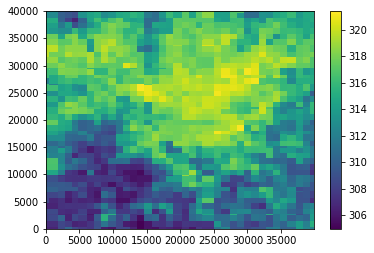

In [50]:
#Check points by plotting
#specify x,y,LSTs
x= gdf2.x_points
y= gdf2.y_points
LST = gdf2.LST

#get the points into the correct format
X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), LST, (X,Y), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X,Y,Z)
plt.colorbar()

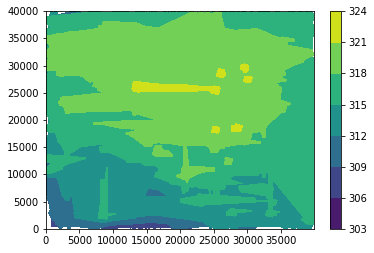

In [9]:
#Contour plot
#Make plot
#Contour plot
plt.contourf(X,Y,Z,levels = 5)
plt.colorbar()

In [51]:
#Now need to decide whether or not data is of sufficient quality to be used
#to do this we will use the QC flag. The QC flag is a bit flag, so need to extract the relevent bytes, and select the data based on these
#first of all need to write a function to extract required bytes
#Then apply the function to the QC list to check bytes 1 and 2. Then append this new list onto our data frame. 

#first off all define the functions

#function to check the status of a byte on the QC control
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag

#Take the QC flags out the dataframe to apply the function to 
QC = gdf2.QC

#Apply to function to QC
QC2 = np.array([quality_control(int(i)) for i in QC])

#And add this QC2 flag onto the dataset
gdf2['QC_2'] = QC2

Text(0, 0.5, 'Y distance')

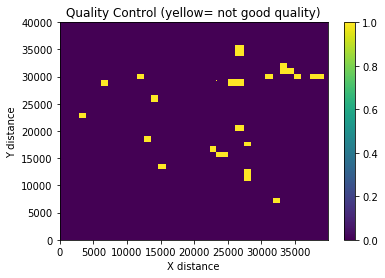

In [11]:
####  OBSERVATION POINT   #####

#Check the points which are not useable based on QC flag

#first grid the QC_2 flag
QC_2 = gdf2.QC_2
QC_Z = scipy.interpolate.griddata((x, y), QC_2, (X,Y), method='nearest')

#Then plot 
plt.pcolormesh(X,Y,QC_Z)
plt.colorbar()
plt.title('Quality Control (yellow= not good quality)')
plt.xlabel('X distance')
plt.ylabel('Y distance')

In [52]:
#Now need to add in the land cover data in order to apply the urban mask
#Will apply the mask to the urban areas and the areas with QC2 flag = 1

#first load in LULC data
#crs wgs84
#code for urban areas: 190

LULC_ds=xr.open_dataset('/neodc/esacci/land_cover/data/land_cover_maps/v2.0.7/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2007-v2.0.7b.nc')

#Take the subset of required area, this must be done to the data array as the dataset is very large and needs to be made smaller before it can be a dataframe
#select a subset (Area containing Milan city centre and 39km around it, taken from Anniballe 2014)
#45.29<lat<45.64, 8.91<lon<9.42
temp_subset_LULC_ds = LULC_ds.sel(lat =(LULC_ds.lat >45.29) & (LULC_ds.lat < 45.65))
subset_LULC_ds = temp_subset_LULC_ds.sel(lon =(temp_subset_LULC_ds.lon >8.91) & (temp_subset_LULC_ds.lon < 9.42))

#Add lat and lon as variables so more easy to use in dataframe
subset_LULC_ds['lats'] = subset_LULC_ds['lat']
subset_LULC_ds['lons'] = subset_LULC_ds['lon']

#send to dataframe
subset_LULC_df = subset_LULC_ds.to_dataframe()

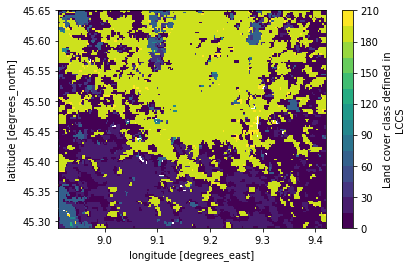

In [13]:
####  OBSERVATION POINT   #####

#To look at the data
lccs_class = subset_LULC_ds.lccs_class
lccs_class.plot(levels = 20)

In [53]:
#Add in is_urban flag, where the lccs_class is 190
subset_LULC_df['is_urban'] = [1 if x == 190 else 0 for x in subset_LULC_df['lccs_class']]

#Convert coordinate system to get into the same x, y format as LSTs
#Change the coordinate reference system
#lat and lon coordinates are not accurate as they are distorted by the shape of the map
subset_LULC_df_geometry = [Point(xy) for xy in zip(subset_LULC_df.lons, subset_LULC_df.lats)]

subset_LULC_gdf = geopandas.GeoDataFrame(subset_LULC_df, geometry=subset_LULC_df_geometry)
subset_LULC_gdf.crs= {'init': 'epsg:4326', 'no_defs': True} #current coordinate system is WGS84, EPSG:4326

subset_LULC_df_gdf2 = subset_LULC_gdf.to_crs(epsg=3003) #epsg 3003 is mainland italy, units in m, cartesian 2D axis

#Extract the x and y coordinates 
lu_x_points = subset_LULC_df_gdf2['geometry'].x
lu_y_points = subset_LULC_df_gdf2['geometry'].y

#Add the extracted coordinates to dataframe
subset_LULC_df_gdf2['xpoints'] = lu_x_points
subset_LULC_df_gdf2['ypoints'] = lu_y_points

#Need this new coordinate grid to be the same as the LST grid, so use the min x,y values from this to set the origin
#Subtract the orgin from the points
subset_LULC_df_gdf2['x_points'] = subset_LULC_df_gdf2['xpoints'] - origin_x
subset_LULC_df_gdf2['y_points'] = subset_LULC_df_gdf2['ypoints'] - origin_y

#Drop the xpoints and ypoints columns as they are no longer needed
subset_LULC_df_gdf2 = subset_LULC_df_gdf2.drop('xpoints', axis = 1)
subset_LULC_df_gdf2 = subset_LULC_df_gdf2.drop('ypoints', axis = 1)

In [54]:
#Check points are added so points can be returned to without having to re-run the code. Here dataframes as saved as pickles. (Note: need to run first line to load libraries still)
########################################################################
########### CHECKPOINT 1 ###############################################
########################################################################
########### WRITE ######################################################

gdf2.to_pickle('checkpoint1_gdf2')
subset_LULC_df_gdf2.to_pickle('checkpoint1_subset_LULC_df_gdf2')

In [4]:
########################################################################
########### CHECKPOINT 1 ###############################################
########################################################################
########### READ #######################################################

gdf2 = pd.read_pickle('checkpoint1_gdf2')
subset_LULC_df_gdf2 = pd.read_pickle('checkpoint1_subset_LULC_df_gdf2')

In [55]:
#In order to add urban flag information from the LULC dataset into the LST dataset we need to work out which points are closest
#The 10 closest points in the land cover dataset to the centre of the LST pixel are calculated and their classification and distance from the pixel centriod added into 
#the LST dataset
#The resolution of the LST dataset is 1000m and LULC dataset is 300m

#first of all add the columns to be filled into the LST dataset. Want to know if the pixel is urban, and also add in distance as a sense check

gdf2['Distance_1'] = 'null'
gdf2['is_urban_1'] = 'null'

gdf2['Distance_2'] = 'null'
gdf2['is_urban_2'] = 'null'

gdf2['Distance_3'] = 'null'
gdf2['is_urban_3'] = 'null'

gdf2['Distance_4'] = 'null'
gdf2['is_urban_4'] = 'null'

gdf2['Distance_5'] = 'null'
gdf2['is_urban_5'] = 'null'

gdf2['Distance_6'] = 'null'
gdf2['is_urban_6'] = 'null'

gdf2['Distance_7'] = 'null'
gdf2['is_urban_7'] = 'null'

gdf2['Distance_8'] = 'null'
gdf2['is_urban_8'] = 'null'

gdf2['Distance_9'] = 'null'
gdf2['is_urban_9'] = 'null'

gdf2['Distance_10'] = 'null'
gdf2['is_urban_10'] = 'null'

#define a distance function to be used to calculate distance from the LST pixel centre and LULC pixel centre
def dist(dataframe,pt_x,pt_y):
    dataframe['Distance'] = np.sqrt(((dataframe['x_points']-pt_x) **2)+(dataframe['y_points']-pt_y)**2)

In [57]:
##For each point in LST, the code runs compares all points in LULC. It then extracts the closest 10 points, saving their indexes and distances
##the index is then used to merge on the is_urban flag and the distance of these closest points

for i in range(len(gdf2)):
    dist(subset_LULC_df_gdf2,gdf2.iloc[i]['x_points'],gdf2.iloc[i]['y_points'])
    smallest_10 = heapq.nsmallest(10, enumerate(subset_LULC_df_gdf2['Distance']),key=operator.itemgetter(1))
   
    gdf2['is_urban_1'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[0][0]]['is_urban']
    gdf2['Distance_1'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[0][0]]['Distance']

    gdf2['is_urban_2'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[1][0]]['is_urban']
    gdf2['Distance_2'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[1][0]]['Distance']
    
    gdf2['is_urban_3'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[2][0]]['is_urban']
    gdf2['Distance_3'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[2][0]]['Distance']
    
    gdf2['is_urban_4'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[3][0]]['is_urban']
    gdf2['Distance_4'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[3][0]]['Distance']
    
    gdf2['is_urban_5'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[4][0]]['is_urban']
    gdf2['Distance_5'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[4][0]]['Distance']
    
    gdf2['is_urban_6'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[5][0]]['is_urban']
    gdf2['Distance_6'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[5][0]]['Distance']
    
    gdf2['is_urban_7'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[6][0]]['is_urban']
    gdf2['Distance_7'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[6][0]]['Distance']
    
    gdf2['is_urban_8'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[7][0]]['is_urban']
    gdf2['Distance_8'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[7][0]]['Distance']
    
    gdf2['is_urban_9'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[8][0]]['is_urban']
    gdf2['Distance_9'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[8][0]]['Distance']
    
    gdf2['is_urban_10'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[9][0]]['is_urban']
    gdf2['Distance_10'].iloc[i] = subset_LULC_df_gdf2.iloc[smallest_10[9][0]]['Distance']
    

In [58]:
#Check points are added so points can be returned to without having to re-run the code. Here dataframes as saved as pickles. (Note: need to run first line to load libraries still)
########################################################################
########### CHECKPOINT 2 ###############################################
########################################################################
########### WRITE ######################################################

gdf2.to_pickle('checkpoint2_gdf2')

In [9]:
########################################################################
########### CHECKPOINT 1 ###############################################
########################################################################
########### READ #######################################################

gdf2 = pd.read_pickle('checkpoint2_gdf2')

In [59]:
##Now assign the classification of the LST pixel
#Calculate the sum of the closest 10 points
gdf2['urban_sum_10'] = gdf2['is_urban_1'] + gdf2['is_urban_2'] + gdf2['is_urban_3'] + gdf2['is_urban_4'] + gdf2['is_urban_5'] + gdf2['is_urban_6'] + \
                       gdf2['is_urban_7'] + gdf2['is_urban_8'] + gdf2['is_urban_9'] + gdf2['is_urban_10'] 


#Then assign and urban overall flag to the pixel if 5 or more of the surronding LULC pixels are urban
gdf2['is_urban_overall_10_5'] = [1 if x >= 5 else 0 for x in gdf2['urban_sum_10']]


Text(0.5, 1.0, 'Urban Pixels (yellow)')

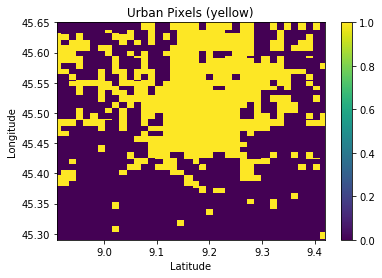

In [32]:
####  OBSERVATION POINT   #####

#Look at urban land cover
#get the points into the correct format
x_lu = gdf2['lon']
y_lu = gdf2['lat']
U_lu = gdf2['is_urban_overall_10_5']

X_lu,Y_lu = np.meshgrid(x_lu,y_lu)
Z_lu = scipy.interpolate.griddata((x_lu, y_lu), U_lu, (X_lu,Y_lu), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X_lu,Y_lu, Z_lu)
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Urban Pixels (yellow)')

In [60]:
##Smoothing
#Now to smooth the image to get rid of the noise
#For this we need to take a LST pixel, then find the nearest 9 pixels to this
#Then the pixel can be recategorised based on the assignment of these 5 or these 10 points
#first make a copy of our main data frame (gdf2) which can be used as the comparison
points_df = gdf2.copy()

#Housekeeping
#Drop the columns in the main dataset and create new ones to be filled
#(best to change the name to avoid any confusion)

gdf2 = gdf2.drop(columns= ['is_urban_1','Distance_1','is_urban_2','Distance_2','is_urban_3','Distance_3','is_urban_4','Distance_4','is_urban_5','Distance_5','is_urban_6','Distance_6'
                      ,'is_urban_7','Distance_7','is_urban_8','Distance_8','is_urban_9','Distance_9','is_urban_10','Distance_10']);


#create the new columns to be filled
gdf2['urban_flag_1'] = 'null'
gdf2['urban_flag_2'] = 'null'
gdf2['urban_flag_3'] = 'null'
gdf2['urban_flag_4'] = 'null'
gdf2['urban_flag_5'] = 'null'
gdf2['urban_flag_6'] = 'null'
gdf2['urban_flag_7'] = 'null'
gdf2['urban_flag_8'] = 'null'
gdf2['urban_flag_9'] = 'null'
gdf2['urban_flag_10'] = 'null'

gdf2['Neighbour1_Distance'] = 'null'   #note: neighbour 1 distance should always be 0 as it is the pixel itself
gdf2['Neighbour2_Distance'] = 'null'
gdf2['Neighbour3_Distance'] = 'null'
gdf2['Neighbour4_Distance'] = 'null'
gdf2['Neighbour5_Distance'] = 'null'
gdf2['Neighbour6_Distance'] = 'null'
gdf2['Neighbour7_Distance'] = 'null'
gdf2['Neighbour8_Distance'] = 'null'
gdf2['Neighbour9_Distance'] = 'null'
gdf2['Neighbour10_Distance'] = 'null'

#define the distance function again
def dist(dataframe,pt_x,pt_y):
    dataframe['Distance'] = np.sqrt(((dataframe['x_points']-pt_x) **2)+(dataframe['y_points']-pt_y)**2)
    

In [61]:
#first of all calculate the distance between the two points 
#then apply this element by element to the main dataframe, against all the points in the LULC dataframe to find the one which is the closest
#Note, here one of the points (the closest) will be distance 0 as this is comparing the point against itself

for i in range(len(gdf2)):
    dist(points_df,gdf2.iloc[i]['x_points'],gdf2.iloc[i]['y_points'])
    smallest_10 = heapq.nsmallest(10, enumerate(points_df['Distance']),key=operator.itemgetter(1))
   
    gdf2['urban_flag_1'].iloc[i] = points_df.iloc[smallest_10[0][0]]['is_urban_overall_10_5']
    gdf2['Neighbour1_Distance'].iloc[i] = points_df.iloc[smallest_10[0][0]]['Distance'] #Add in the distance as a sense check 
    
    gdf2['urban_flag_2'].iloc[i] = points_df.iloc[smallest_10[1][0]]['is_urban_overall_10_5']
    gdf2['Neighbour2_Distance'].iloc[i] = points_df.iloc[smallest_10[1][0]]['Distance']
   
    gdf2['urban_flag_3'].iloc[i] = points_df.iloc[smallest_10[2][0]]['is_urban_overall_10_5']
    gdf2['Neighbour3_Distance'].iloc[i] = points_df.iloc[smallest_10[2][0]]['Distance']
    
    gdf2['urban_flag_4'].iloc[i] = points_df.iloc[smallest_10[3][0]]['is_urban_overall_10_5']
    gdf2['Neighbour4_Distance'].iloc[i] = points_df.iloc[smallest_10[3][0]]['Distance']
    
    gdf2['urban_flag_5'].iloc[i] = points_df.iloc[smallest_10[4][0]]['is_urban_overall_10_5']
    gdf2['Neighbour5_Distance'].iloc[i] = points_df.iloc[smallest_10[4][0]]['Distance']
    
    gdf2['urban_flag_6'].iloc[i] = points_df.iloc[smallest_10[5][0]]['is_urban_overall_10_5']
    gdf2['Neighbour6_Distance'].iloc[i] = points_df.iloc[smallest_10[5][0]]['Distance']
    
    gdf2['urban_flag_7'].iloc[i] = points_df.iloc[smallest_10[6][0]]['is_urban_overall_10_5']
    gdf2['Neighbour7_Distance'].iloc[i] = points_df.iloc[smallest_10[6][0]]['Distance']
   
    gdf2['urban_flag_8'].iloc[i] = points_df.iloc[smallest_10[7][0]]['is_urban_overall_10_5']
    gdf2['Neighbour8_Distance'].iloc[i] = points_df.iloc[smallest_10[7][0]]['Distance']
    
    gdf2['urban_flag_9'].iloc[i] = points_df.iloc[smallest_10[8][0]]['is_urban_overall_10_5']
    gdf2['Neighbour9_Distance'].iloc[i] = points_df.iloc[smallest_10[8][0]]['Distance']
    
    gdf2['urban_flag_10'].iloc[i] = points_df.iloc[smallest_10[9][0]]['is_urban_overall_10_5']
    gdf2['Neighbour10_Distance'].iloc[i] = points_df.iloc[smallest_10[9][0]]['Distance']

In [70]:
#Check points are added so points can be returned to without having to re-run the code. Here dataframes as saved as pickles. (Note: need to run first line to load libraries still)
########################################################################
########### CHECKPOINT 3 ###############################################
########################################################################
########### WRITE ######################################################
gdf2.to_pickle('checkpoint3_gdf2')

In [113]:
########################################################################
########### CHECKPOINT 3 ###############################################
########################################################################
########### READ #######################################################

gdf2 = pd.read_pickle('checkpoint3_gdf2')

In [114]:
#Sum the smoothing points to calculate overall proportion in each
gdf2['smoothing_sum'] = gdf2['urban_flag_1'] + gdf2['urban_flag_2'] + gdf2['urban_flag_3'] + gdf2['urban_flag_4'] + gdf2['urban_flag_5'] + gdf2['urban_flag_6'] + \
                        gdf2['urban_flag_7'] + gdf2['urban_flag_8'] + gdf2['urban_flag_9'] + gdf2['urban_flag_10']

#Decide whether the points are classified as urban or not based on whether or not 5 or more are urban 
gdf2['is_urban'] = [1 if x >= 5 else 0 for x in gdf2['smoothing_sum']]

#Housekeeping
#Drop the columns which are no longer needed now we have the urban mask 

gdf2 = gdf2.drop(columns= ['urban_flag_1','Neighbour1_Distance','urban_flag_2','Neighbour2_Distance','urban_flag_3','Neighbour3_Distance','urban_flag_4','Neighbour4_Distance'
                    ,'urban_flag_5','Neighbour5_Distance','urban_flag_6','Neighbour6_Distance','urban_flag_7','Neighbour7_Distance','urban_flag_8','Neighbour8_Distance'
                    ,'urban_flag_9','Neighbour9_Distance','urban_flag_10','Neighbour10_Distance']);


In [115]:
#convert x and y points into km
gdf2['x_points'] /= 1000
gdf2['y_points'] /= 1000

In [116]:
#Now need to apply the urban mask
#The first step is to mask out all the urban pixels and cloudy pixels
#So apply mask flag set to 1 if QC_2 = 1 OR if is_urban = 1

#Create the function
def to_mask(row):
    if row['QC_2'] == 1:
        return 1
    elif row['is_urban'] == 1:
        return 1
    else:
        return 0

#Apply to create new column
gdf2['apply_mask'] = gdf2.apply(lambda row: to_mask(row), axis=1)

#Select a subset of the data, which the mask has not been applied to (this is the rural area) 
#will then apply a mulitple linear regression (with 2 variables, x and y) to this subset to get something of the form
# LST = T0 + (a1)x + (a2)y
#T0, a1, a2 coefficients to be determined

#first create a copy of the main dataframe to use
rural_df = gdf2.copy()

#select the required rows of the unmasked variables (where apply_mask = 0)
rural_df = rural_df.loc[rural_df['apply_mask'] == 0]

#take out useful columns
#(just to get a smaller dataset to work with, as other columns not needed)
rural_df1 = rural_df[['lat','lon','LST','x_points','y_points']].copy()


In [117]:
####  OBSERVATION POINT   #####

#Check if any of the data is null
rural_df1.isnull().any()

lat         False
lon         False
LST         False
x_points    False
y_points    False
dtype: bool

Text(0, 0.5, 'LST')

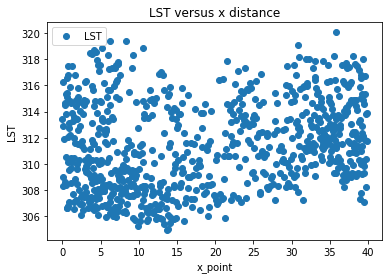

In [118]:
####  OBSERVATION POINT   #####

#First want to look at the distribution of the data to check it satisfies the criteria for a linear regression to be applied 
#Look at distribution for x distance
rural_df1.plot(x='x_points', y='LST', style = 'o')
plt.title('LST versus x distance')
plt.xlabel('x_point')
plt.ylabel('LST')


Text(0, 0.5, 'LST')

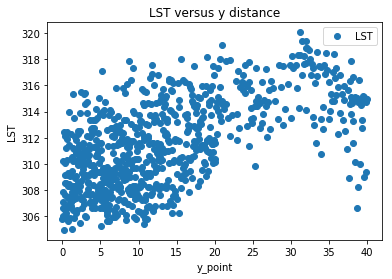

In [119]:
####  OBSERVATION POINT   #####

#Look at distribution for y distance
rural_df1.plot(x='y_points', y='LST', style = 'o')
plt.title('LST versus y distance')
plt.xlabel('y_point')
plt.ylabel('LST')

In [120]:
####  OBSERVATION POINT   #####

#seaborn isn't in the jasmin environment, so save dataframe as a pickle, download and do seaborn analysis separately
rural_df1.to_pickle('rural_df1')


In [121]:
#Perform stats tests
#perform a ks test to see if the distribution of LST is normal
from scipy.stats import norm, kstest
#x is a list of the LSTs
x= rural_df1['LST'].tolist()

#generate what the normal distribution parameters of this would be 
loc, scale = norm.fit(x)
n=norm(loc=loc, scale=scale)

ks_result = stats.kstest(x, n.cdf)

#Result: KstestResult(statistic=0.061, pvalue=0.0055)

#perform a shapiro wilks test
shapiro_result = stats.shapiro(x)

#Result: 0.97, 1.84e-10

print("ks_test", ks_result)
print("shapiro_test", shapiro_result)      

ks_test KstestResult(statistic=0.06075657447761701, pvalue=0.005529394634733675)
shapiro_test (0.9747644662857056, 1.8448942373794353e-10)


In [122]:
#Perform regression
#Divide the data into attributes and labels

X= rural_df1[['x_points','y_points']].values

y = rural_df1['LST'].values

#Split the data, 80% to training set, 20% to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 0)

#Fit the model to the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#Look at the coefficients and intercept
X = pd.DataFrame(X) #had to convert from np array to panda dataframe to use .columns
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
intercept = regressor.intercept_

#print the coefficients and intercept
print(coeff_df)
print("Intercept", intercept)

#Use the regression model to make a prediction using the test data
y_pred = regressor.predict(X_test)

pred_df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})

pred_df1 = pred_df.head(25)

   Coefficient
0     0.075881
1     0.201425
Intercept 307.2501468170717


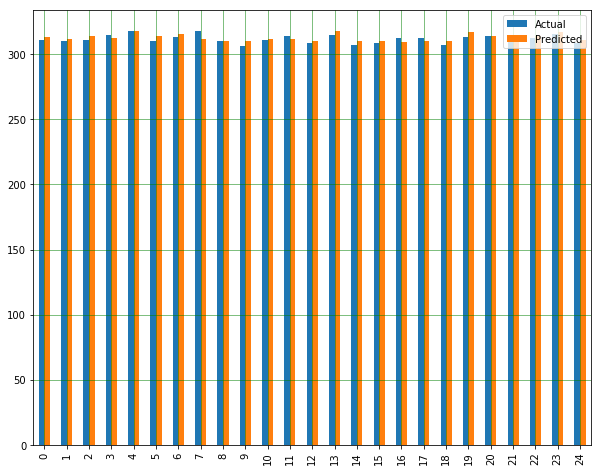

In [123]:
####  OBSERVATION POINT   #####

#Comparison plot of actual and predicted values
pred_df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [124]:
####  OBSERVATION POINT   #####

#Evaluate performance of the regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.2043888535339082
Mean Squared Error: 7.240147982735197
Root Mean Squared Error: 2.6907523079494324


In [125]:
#Now the regression has been created, this will be used to predict T_0
#This will give a baseline for what the temperature would be in the urban area if it was rural

#create the column T_0 with the predicted rural baseline temperatures

pred_input = gdf2[['x_points','y_points']].values
gdf2['T_0_pred'] = regressor.predict(pred_input)

#Take the predicted baseline temperature away from the LST to get the SUHI footprint 
gdf2['SUHI'] = gdf2['LST']- gdf2['T_0_pred']

#Now to start to model the SUHI
#Need to take only pixels which are good quality (QC_2 = 0)
#Still include rural pixels 
SUHI_df = gdf2.copy()

SUHI_df = SUHI_df.loc[SUHI_df['QC_2'] == 0]

In [126]:
####  OBSERVATION POINT   #####

#counting how many points have SUHI negative or positive
j = gdf2['SUHI']

len([1 for i in j if i > 0])

#976 positive SUHI
#517 negative SUHI

976

Text(0.5, 1.0, 'SUHI')

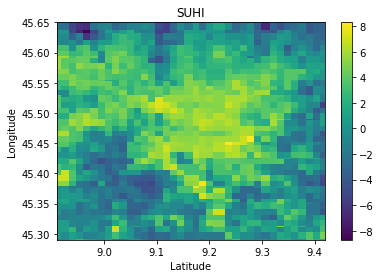

In [127]:
####  OBSERVATION POINT   #####

#SUHI_df
#Take a look at the SUHI
#make the grids
x_suhi = SUHI_df['lon']
y_suhi = SUHI_df['lat']
U_suhi = SUHI_df['SUHI']

X_suhi,Y_suhi = np.meshgrid(x_suhi,y_suhi)
Z_suhi = scipy.interpolate.griddata((x_suhi, y_suhi), U_suhi, (X_suhi,Y_suhi), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X_suhi,Y_suhi, Z_suhi)
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('SUHI')

In [128]:
#add in the column containing the logs
#There are two options for dealing with the negative results

#1 Remove all results which are 0 or less 
#Create a dataset containing only the values for SUHI greater than 0
Pos_SUHI_df = SUHI_df.loc[SUHI_df['SUHI'] > 0].copy()

#take logs
Pos_SUHI_df['ln_SUHI'] = np.log(Pos_SUHI_df['SUHI'])

#2 Add the magnitude of the lowest value onto all data so are all positive (although the lowest value will be 0 and therefore cannot be used- ln0 doesn't exist)

#take out useful columns and define lists for analysis later and plotting
urban_df1 = Pos_SUHI_df[['lat','lon','ln_SUHI','SUHI','x_points','y_points']].copy()
x_points = urban_df1['x_points']
y_points = urban_df1['y_points']
SUHI = urban_df1['SUHI']
ln_SUHI = urban_df1['ln_SUHI']


Text(0.5, 1.0, 'SUHI')

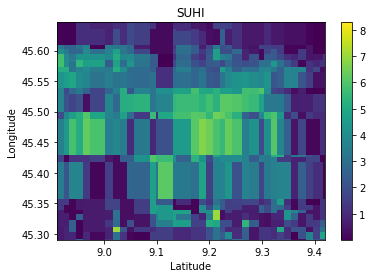

In [129]:
####  OBSERVATION POINT   #####

#Take a look at the SUHI
#make the grids
x_suhi = Pos_SUHI_df['lon']
y_suhi = Pos_SUHI_df['lat']
U_suhi = Pos_SUHI_df['SUHI']

X_suhi,Y_suhi = np.meshgrid(x_suhi,y_suhi)
Z_suhi = scipy.interpolate.griddata((x_suhi, y_suhi), U_suhi, (X_suhi,Y_suhi), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X_suhi,Y_suhi, Z_suhi)
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('SUHI')

[Text(0, 0.5, 'ln(SUHI)'), Text(0.5, 0, 'y distance')]

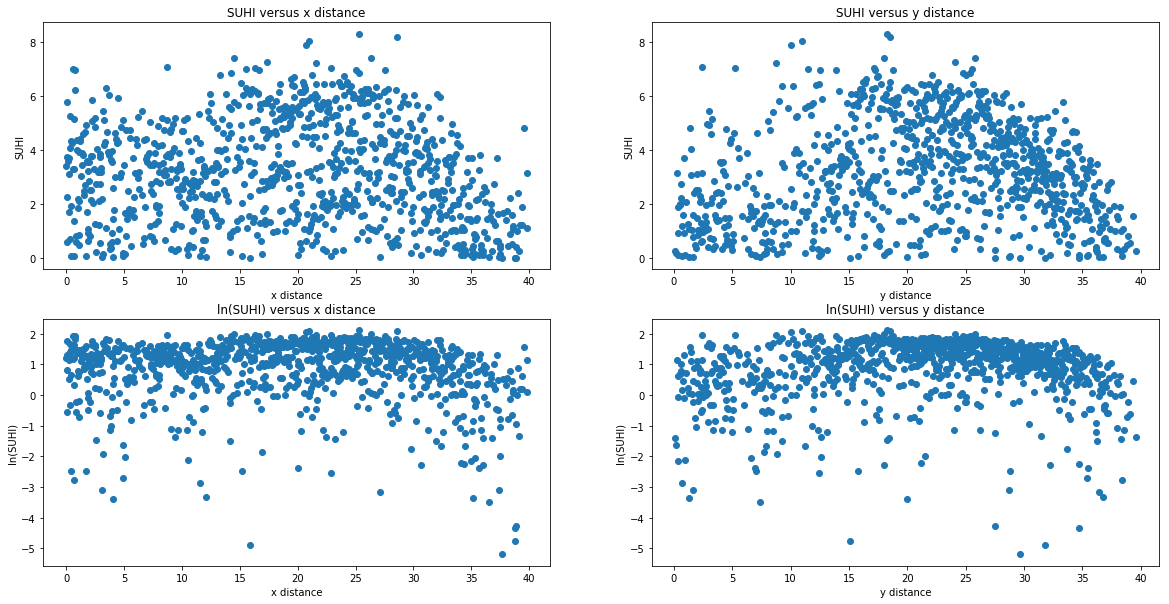

In [130]:
####  OBSERVATION POINT   #####

#Scatterplots
#Look at distribution for x and y distances

fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize=(20, 10))

axes[0,0].scatter(x_points, SUHI)
axes[0,0].set_title('SUHI versus x distance')
axes[0,0].set(xlabel = 'x distance', ylabel = 'SUHI')

axes[0,1].scatter(y_points, SUHI)
axes[0,1].set_title('SUHI versus y distance')
axes[0,1].set(xlabel = 'y distance', ylabel = 'SUHI')

axes[1,0].scatter(x_points, ln_SUHI)
axes[1,0].set_title('ln(SUHI) versus x distance')
axes[1,0].set(xlabel = 'x distance', ylabel = 'ln(SUHI)')

axes[1,1].scatter(y_points, ln_SUHI)
axes[1,1].set_title('ln(SUHI) versus y distance')
axes[1,1].set(xlabel = 'y distance', ylabel = 'ln(SUHI)')


In [6]:
#Polynomial regression
#equation is of form ln_SUHI = b1 (x^2) +b2 xy +b3 y^2 + b4 x + b5 y + b6

#set variables to use
#Divide the data into attributes and labels

X = urban_df1[['x_points','y_points']].values
poly= PolynomialFeatures(degree=2) #
X_poly = poly.fit_transform(X)      #generate the polynomial and interaction feature in form [1, a, b, a^2, ab, b^2]
                                    #so column 0:1 c1:x c2:y c3:x^2 c4: xy c5:y^2

y = urban_df1['ln_SUHI'].values

#Split the data, 80% to training set, 20% to test set
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size= 0.2, random_state = 0) # note: Shuffle = True by default

#Fit the model to the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#Look at the coefficients and intercept
Xpoly = pd.DataFrame(X_poly) #had to convert from np array to panda dataframe to use .columns
coeff_df = pd.DataFrame(regressor.coef_, Xpoly.columns, columns=['Coefficient'])  
intercept = regressor.intercept_

print(coeff_df)
print("intercept", intercept)

#Use the regression model to make a prediction using the test data
y_pred = regressor.predict(X_test)

pred_df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})

pred_df_SUHI = np.exp(pred_df)

pred_df1 = pred_df.head(25)
pred_df1_SUHI = pred_df_SUHI.head(25)


   Coefficient
0     0.000000
1     0.139892
2     0.182442
3    -0.003036
4    -0.001811
5    -0.003556
intercept -1.5551600752799413


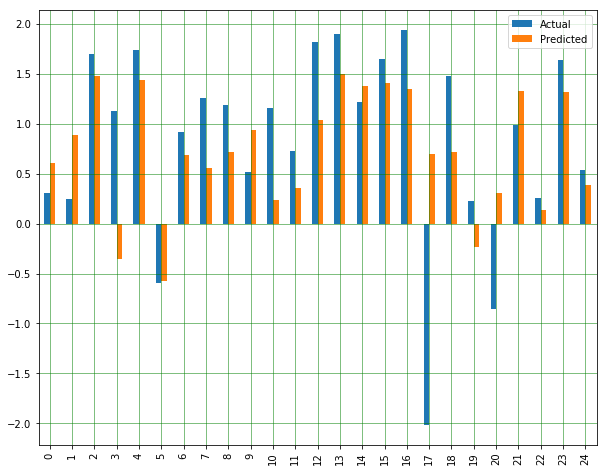

In [132]:
####  OBSERVATION POINT   #####

#Use the regression model to make a prediction using the test data
y_pred = regressor.predict(X_test)

pred_df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})

pred_df_SUHI = np.exp(pred_df)

pred_df1 = pred_df.head(25)
pred_df1_SUHI = pred_df_SUHI.head(25)

#Comparison plot of actual and predicted values for ln(SUHI)
pred_df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

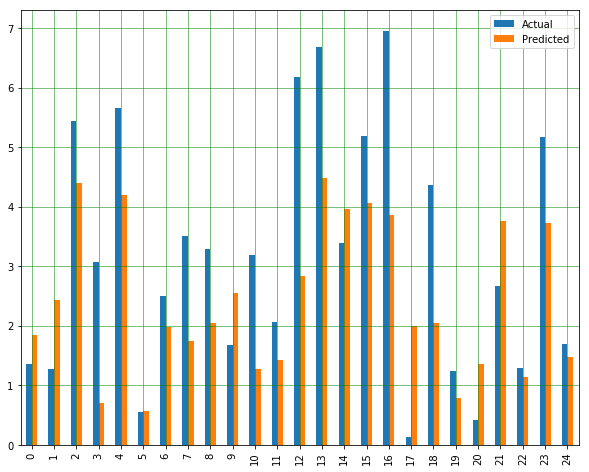

In [133]:
####  OBSERVATION POINT   #####

#Comparison plot of actual and predicted values for SUHI
pred_df1_SUHI.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [134]:
####  OBSERVATION POINT   #####

#Evaluate performance of the regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.6139752189977437
Mean Squared Error: 0.7527150493176047
Root Mean Squared Error: 0.8675915221563686


In [7]:
#Now start the non linear least squares approximation
#First of all need to solve the equations with coefficients calculated via log-linear regresion to get inital guess parameters
#column 0:1 c1:x c2:y c3:x^2 c4: xy c5:y^2

beta1 = coeff_df['Coefficient'][3]  #x^2 coeff
beta2 = coeff_df['Coefficient'][4]  #xy coeff
beta3 = coeff_df['Coefficient'][5]  #y^2 coeff
beta4 = coeff_df['Coefficient'][1]  #x coeff
beta5 = coeff_df['Coefficient'][2]  #y coeff
beta6 = regressor.intercept_

beta = (beta1, beta2, beta3, beta4, beta5, beta6)

In [136]:
gdf2.to_pickle('temp_gdf2')
SUHI_df.to_pickle('temp_SUHI_df')
coeff_df.to_pickle('temp_coeff_df')
temp_beta = pd.DataFrame([beta1, beta2, beta3, beta4, beta5, beta6])
temp_beta.to_pickle('temp_beta')
urban_df1.to_pickle('temp_urban_df1')

In [3]:
#checkpoint/ temporary starting from here so load in
gdf2 = pd.read_pickle("temp_gdf2")
SUHI_df = pd.read_pickle("temp_SUHI_df")
coeff_df = pd.read_pickle("temp_coeff_df")
temp_beta = pd.read_pickle("temp_beta")
urban_df1 = pd.read_pickle("temp_urban_df1")

In [9]:
#gdf2['is_urban']

In [8]:
#Solve the simultaneous equations to get the initial guess parameters
#Levenberg-Marquardt method used

def fun(x):
    # x = [x0, y0, lna0, ax, ay, phi]
    # contains the equations to solve
    cphi = np.cos(x[5])
    sphi = np.sin(x[5])
    ax2 = x[3]**2
    ay2 = x[4]**2
    return [
        beta[0] - (-2*cphi**2/ax2 - 2*sphi**2/ay2),                                                            #beta 1
        beta[1] - (-4*cphi*sphi/ax2 + 4*cphi*sphi/ay2),                                                        #beta 2
        beta[2] - (-2*sphi**2/ax2 - 2*cphi**2/ay2),                                                            #beta 3
        beta[3] - (4*x[0]*cphi**2/ax2 + 4*x[1]*cphi*sphi/ax2 - 4*x[1]*cphi*sphi/ay2 + 4*x[0]*sphi**2/ay2),     #beta 4
        beta[4] - (4*x[0]*cphi*sphi/ax2 + 4*x[1]*cphi**2/ax2 + 4*x[1]*cphi**2/ay2 - 4*x[0]*cphi*sphi/ay2),     #beta 5
        beta[5] - (x[2] - (2/ax2)*((x[0]**2)*cphi**2 + 2*x[0]*x[1]*cphi*sphi + (x[1]**2)*sphi**2)              #beta 6
                   - (2/ay2)*((x[1]**2)*cphi**2 - 2*x[0]*x[1]*cphi*sphi + (x[0]**2)*sphi**2))

    ]

def jac(x):
    #jacobian- matrix containing the partial derivatives
    cphi = np.cos(x[5])
    sphi = np.sin(x[5])
    cphi2 = cphi**2
    sphi2 = sphi**2
    ax2 = x[3]**2
    ay2 = x[4]**2
    ax3 = x[3]**3
    ay3 = x[4]**3
    x0 = x[0]
    y0 = x[1]
    return np.array([
        # partial derivatives
        
        [0, 0, 0, 4*cphi2/ax3, 4*sphi2/ay3, 4*sphi*cphi/ax2 - 4*cphi*sphi/ay2], 
        
        [0, 0, 0, 8*cphi*sphi/ax3, 8*cphi*sphi/ay3, (-8/ax2 - 8/ay2)*(cphi2 - sphi2)],
        
        [0, 0, 0, 4*sphi2/ax3, 4*cphi2/ay3, -4*sphi*cphi/ax2 + 4*sphi*cphi/ay2],
        
        [4*cphi2/ax2 + 4*sphi2/ay2, 4*cphi*sphi/ax2-4*cphi*sphi/ay2, 0, -8*x0*cphi2/ax3 - 8*y0*cphi*sphi, 8*y0*cphi*sphi/ay3 - 8*x0*sphi2/ay3, 
         -8*x0*cphi*sphi/ax2 + (4*y0/ax2-4*y0/ay2)*(cphi2 - sphi2) + 8*x0*sphi*cphi/ay2],
        
        [4*cphi*sphi*(1/ax2 - 1/ay2), 4*sphi2/ax2 + 4*cphi/ay2, 0, -8*x0*cphi*sphi/ax3 - 8*y0*sphi2/ax3, 
         -8*y0*cphi2/ay3 + 8*x0*cphi*sphi/ay3, (1/ax2-1/ay2)*4*x0*(sphi2-cphi2) + (1/ax2-1/ay2)*(16*y0*cphi*sphi)],
        
        [-(2/ax2)*(2*x0*cphi2+2*y0*cphi*sphi)-(2/ay2)*(2*x0*sphi2-2*y0*cphi*sphi), -(2/ax2)*(2*x0*cphi*sphi+2*y0*sphi2)-(2/ay2)*(2*y0*cphi2-2*x0*cphi*sphi),
        1, (4/ax3)*(x0**2*cphi2 + 2*x0*y0*cphi*sphi+y0**2*sphi2), (4/ay3)*(y0**2*cphi2 - 2*x0*y0*cphi*sphi + x0**2*sphi2),
        (-2/ax2)*(-2*x0**2*cphi*sphi + 2*x0*y0*(cphi2-sphi2)+2*y0**2*cphi*sphi) - (2/ay2)*(-2*y0**2*cphi*sphi - 2*x0*y0*(cphi2-sphi2)+2*x0**2*cphi*sphi)]
        
        ])
guess = 0.001
x0 = np.array([guess,guess,guess,guess,guess,guess])
#x0 = np.array([10,10,3,3,3,-0.5])
sol = optimize.root(fun, x0, jac=jac, tol=1e-35, method='lm', options={'xtol': 1e-35})

# x = [x0, y0, lna0, ax, ay, phi] 

In [9]:
#Fit to the Gaussian surface 

def SUHIfunc(Z,a0,x0,y0,phi,ax,ay):
    x,y = Z
    return a0 * np.exp(((-((x-x0)*np.cos(phi)+(y-y0)*np.sin(phi))**2)/(0.5*(ax**2)))-((((y-y0)*np.cos(phi)-(x-x0)*np.sin(phi))**2)/(0.5*(ay**2))))

# data
x = urban_df1['x_points'].values
y = urban_df1['y_points'].values
#a0, x0, y0, phi, ax, ay = 6., 6., 6., 0.5., 3., 3.
z = urban_df1['SUHI'].values

# initial guesses for a0,x0,y0,phi,ax,ay:
p0 = 2., -1.3, 4, -0.6, 100., 250. 
popt, pcov = curve_fit(SUHIfunc, (x,y), z, p0, maxfev=5000)

In [10]:
popt

array([  5.12375621,  18.89363393,  21.21963006,  -5.10911219,
       -23.78196761, -33.35632383])

In [11]:
pcov

array([[ 1.26374146e-02, -2.89147472e-04, -2.05239009e-03,
        -3.65595227e-04,  4.31348604e-02,  8.92046101e-02],
       [-2.89147472e-04,  1.94984349e-01, -2.99688587e-02,
        -1.24621911e-03,  4.79031988e-02, -5.53542648e-02],
       [-2.05239009e-03, -2.99688587e-02,  1.04217979e-01,
        -2.68955449e-03,  1.24985239e-02, -6.35119563e-03],
       [-3.65595227e-04, -1.24621911e-03, -2.68955449e-03,
         5.17755134e-03,  3.85899785e-04, -1.82234169e-02],
       [ 4.31348604e-02,  4.79031988e-02,  1.24985239e-02,
         3.85899785e-04,  6.11517733e-01,  1.75587384e-02],
       [ 8.92046101e-02, -5.53542648e-02, -6.35119563e-03,
        -1.82234169e-02,  1.75587384e-02,  1.95203904e+00]])